In [14]:
dpath = "drive/My Drive/"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
# Read Captions
def readcaptions(path):
    f = open(path)
    text = f.read()
    f.close()
    captions = {}
    for line in text.split("\n")[:-1]:
        pid , cap = line.split("\t")
        pid = pid[:-2]
        if(captions.get(pid)==None):
            captions[pid] = [cap]
        else:
            captions[pid].append(cap)
            
    return captions

captions = readcaptions(dpath + "flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")


In [17]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

### Show data 

In [18]:
def show_data(pid):
    path = dpath + "flickr8k/Flickr_Data/Flickr_Data/Images/"+pid 
    img = cv.imread(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    for i ,cap in enumerate(captions[pid]):
        print(i+ 1 , cap)

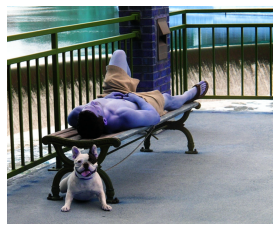

1 A man lays on a bench while his dog sits by him .
2 A man lays on the bench to which a white dog is also tied .
3 a man sleeping on a bench outside with a white and black dog sitting next to him .
4 A shirtless man lies on a park bench with his dog .
5 man laying on bench holding leash of dog sitting on ground


In [19]:
temp_img = list(captions.keys())[3]
show_data(temp_img)

In [20]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-z]+" , " " , text)
    text = text.split()
    
    #text = [ word for word in text if len(word) > 1]
    text = " ".join(text)

    return text
    
    return text
clean_text("My phone number is 94669#####")

'my phone number is'

### ALL Caption cleaning

In [21]:
for key , cap in captions.items():
    for i in range(len(cap)):
        captions[key][i] = clean_text(cap[i])

## Creating Vocab

In [22]:
vocab = set()
for key in captions.keys():
    for line in captions[key]:
        vocab.update(line.split())
        
len(vocab)

8441

In [23]:
#all words
total_words = []

for key in captions.keys():
    for line in captions[key]:
        total_words.extend(line.split())
        
len(total_words)

437466

In [24]:
#Word frequency

word_freq ={}
for word in total_words:
    if(word_freq.get(word) == None):
        word_freq[word] = 1
    else:
        word_freq[word] += 1
        


In [25]:
new_vocab = set()
for vword in vocab:
    if(word_freq[vword] > 10):
        new_vocab.add(vword)
    
len(new_vocab)


1850

In [26]:
def readfiles(path):
    f = open(path)
    text = f.read()
    f.close()
    return text

## Seprating Train and Test data

In [27]:
train_data = readfiles(dpath+"flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train = [row for row in train_data.split("\n")[:-1]]
print(len(train))

test_data = readfiles(dpath+"flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
test = [row for row in test_data.split("\n")[:-1]]
print(len(test))

6000
1000


## Tweak -  Adding start and end token to training data 

In [28]:
train_description = {}

for img_id in train:
    train_description[img_id] = []
    for cap in captions[img_id]:
        new_cap = "startseq " + cap + " endseq"
        train_description[img_id].append(new_cap)

train_description[temp_img]

['startseq a man lays on a bench while his dog sits by him endseq',
 'startseq a man lays on the bench to which a white dog is also tied endseq',
 'startseq a man sleeping on a bench outside with a white and black dog sitting next to him endseq',
 'startseq a shirtless man lies on a park bench with his dog endseq',
 'startseq man laying on bench holding leash of dog sitting on ground endseq']

## Transfer Learning

### Images

In [29]:
from keras.applications.resnet50 import ResNet50

In [30]:
model = ResNet50(weights="imagenet" , input_shape= (224,224 ,3))

In [31]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [32]:
from keras.models import Model 

In [33]:
model_new = Model(model.input , model.layers[-2].output)

In [34]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

path = dpath + "flickr8k/Flickr_Data/Flickr_Data/Images/"

def preprocess_img(img):
    path = dpath + "flickr8k/Flickr_Data/Flickr_Data/Images/"
    img = image.load_img(path + img , target_size=(224 , 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img , axis = 0)
    #Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


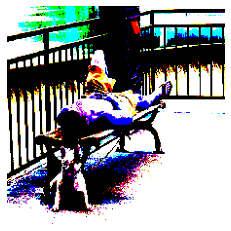

In [35]:
img = preprocess_img(temp_img)
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [36]:
model_new.predict(img)

array([[0.09649309, 0.11092069, 0.20724533, ..., 0.27703032, 0.43025973,
        0.48420373]], dtype=float32)

In [37]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

encode_image(temp_img)

array([0.09649309, 0.11092069, 0.20724533, ..., 0.27703032, 0.43025973,
       0.48420373], dtype=float32)

In [38]:
from time import time
# Encoding Images
def Encode_IMG(img_id_list):
    start = time()
    encoding_data = {}

    for i,img_id in enumerate(img_id_list):
        encoding_data[img_id]  = encode_image(img_id)
        if(i%100==0):
            print("step ==> ", i)
        
    end = time()
    print("Total time ==> " , end - start)
    
    return encoding_data
    

In [39]:
"""
encoding_train = Encode_IMG(train[:100])

import pickle
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)
"""
import pickle 

f = open(dpath + "Capstone/saved/encoded_train_features.pkl" , "rb")
encoding_train = pickle.load(f)
f.close()



In [40]:
"""
encoding_test = Encode_IMG(test)
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)
"""
f = open(dpath + "Capstone/saved/encoded_test_features.pkl" , "rb")
encoding_test = pickle.load(f)
f.close()


### Data pre-processing for captions

In [41]:
#Vocab
len(new_vocab)

1850

In [91]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(new_vocab):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    
print(len(idx_to_word))

1850


In [96]:
# Two special words
idx_to_word[1851] = 'startseq'
word_to_idx['startseq'] = 1851

idx_to_word[1852] = 'endseq'
word_to_idx['endseq'] = 1852

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1853


In [97]:
max_len = 0 
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)
max_len = 32

38


## Data Generator

In [98]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [99]:
def data_gen(descriptions , encoding , word_to_idx, max_len , batch_size ):  
    X1 = []
    X2 = []
    Y = []
    
    n = 0
    while True:
        for key , desc_list in descriptions.items():
            n+=1
            photo = encoding[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx ]
                
                for i in range(len(seq)):
                    xi = seq[:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi] , maxlen= max_len ,value = 0 , padding='post')[0]
                    yi = to_categorical([yi] ,num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                    
                if(n==batch_size):
                    yield [[np.array(X1) , np.array(X2)] , np.array(Y)]
                    X1 = []
                    X2 = []
                    Y = []
                    n = 0
        

In [100]:
type(encoding_train)

dict

## Word Embeddings ( Transfer Learning)

In [101]:
f = open(dpath + "Capstone/saved/glove.6B.50d.txt",encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

f.close()

embedding_index["samsung"]

array([ 0.038318 , -0.47761  ,  1.5479   ,  2.1977   , -0.37663  ,
       -0.3043   ,  0.43616  , -0.88477  , -0.16857  ,  0.65115  ,
        0.79176  , -0.2107   , -0.7319   , -0.4491   , -0.1263   ,
        0.68891  , -1.0975   ,  1.1121   , -0.0386   , -0.42534  ,
        0.47778  , -0.51349  , -0.35801  , -0.81789  , -0.8123   ,
       -0.78331  , -0.27652  , -0.27396  , -1.3298   , -0.96249  ,
        1.2821   ,  0.0098853,  0.57195  ,  0.72032  , -0.0028576,
       -0.52664  , -0.23956  , -0.055702 , -0.26017  , -1.5175   ,
        0.20478  , -0.50222  , -0.2321   , -0.0041807,  1.5633   ,
       -0.79419  ,  0.34273  ,  0.25563  , -0.64646  , -0.45282  ])

In [102]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [103]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape


(1853, 50)

## Model Architecture

In [104]:
from keras.layers import Input , Dense ,  Dropout , Embedding , LSTM
from keras.layers.merge import add

In [105]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [106]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [107]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [108]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 50)       92650       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [109]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [110]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## Training of Model

In [112]:
epochs = 10
batch_size = 3
number_pics_per_batch = 4
steps = len(train_description)//number_pics_per_batch

In [113]:
def training(): 
    for i in range(epochs):
        generator = data_gen(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save(dpath + 'Capstone/model/model_'+str(i)+'.h5')
        test_image()
        

In [114]:
training()

Output hidden; open in https://colab.research.google.com to view.

In [61]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [80]:
def test_image():
  photo_2048 = encoding_test[test_temp].reshape((1,2048))
  caption  = predict_caption(photo_2048)
  i = plt.imread(dpath + "flickr8k/Flickr_Data/Flickr_Data/Images/" + test_temp)
  plt.title(caption)
  plt.imshow(i)
  plt.axis("off")
  plt.show()

In [84]:
test_temp = test[5]
test_temp

'2654514044_a70a6e2c21.jpg'

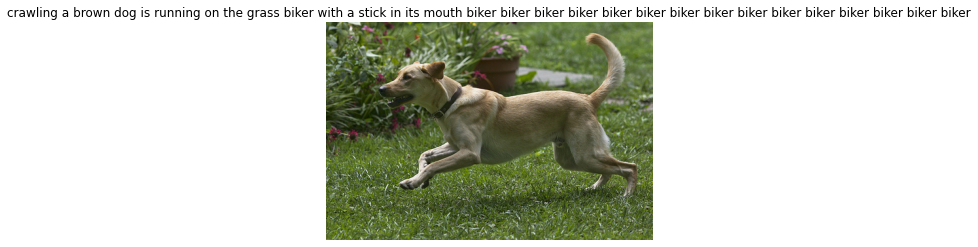

In [94]:

test_image()

In [95]:
word_to_idx["biker"]

1847